# XGBoost

* Performs xgboost on training data. 
* Iterates over parameters with cross validation
* Currently ignoring date parameters due to large number of factors. Waiting for preprocessing steps to improve. 
* Warning: takes a long time to cross validate

In [7]:
# Libraries
library(xgboost)
library(dplyr)
library(Matrix)
library(data.table)
library(Ckmeans.1d.dp)
library(e1071)
library(caret)

# Set Seed
set.seed(1066)

In [3]:
# Read data
# remove id and date_first_booking as they are not relevant
# CURRENTLY REMOVESDATE PARAMETERS AS WELL
tr <- readRDS("../Data/train_users_2_tr.RDS") %>%
    na.omit() %>%
    select(-c(id, date_first_booking)) %>%
    select(-c(date_account_created, date_first_booking, first_browser)) ## Removing more complex factors

ts <- readRDS("../Data/train_users_2_ts.RDS") %>%
    na.omit() %>%
    select(-c(id, date_first_booking)) %>%
    select(-c(date_account_created, first_browser)) ## Removing more complex factors

test <- read.csv("../test_users.csv") %>%
    na.omit() %>%
    select(-id, -date_first_booking)

In [25]:
# One-hot encoding  
# https://cran.r-project.org/web/packages/xgboost/vignettes/discoverYourData.html
tr <- data.table(tr, keep.rownames = F)
sparse_tr <- sparse.model.matrix(country_destination~. -1, data = tr)
dim(sparse_tr)

ts <- data.table(ts, keep.rownames = F)
sparse_ts <- sparse.model.matrix(country_destination~. -1, data = ts)
dim(sparse_ts)

test <- data.table(test, keep.rownames = F)
sparse_test <- sparse.model.matrix(~., data = test)
dim(sparse_test)

[1] 93985    75

[1] 31476    75

ERROR: Error in data.table(test, keep.rownames = F): object 'test' not found


ERROR: Error in terms.formula(object, data = data): object 'test' not found


ERROR: Error in eval(expr, envir, enclos): object 'sparse_test' not found


In [8]:
# Parameter search using Cross validation
# http://stats.stackexchange.com/questions/171043/how-to-tune-hyperparameters-of-xgboost-trees
# Currently using low number of rounds to test

# set up the cross-validated hyper-parameter search
xgb_grid_1 = expand.grid(
    nrounds = 50,                   # Iterations building each XGB model
    max_depth = c(2, 4, 6, 8, 10),   # Maximum tree depth
    eta = c(0.01, 0.001, 0.0001),    # Learning rate
    gamma = 1,                       # Min loss reduction required to make a partition on leaf node [0:inf]
    colsample_bytree = 0.3,          # proportion of features used in each tree
    min_child_weight = 1
)

# trainControl creates settings for caret::train
xgb_trcontrol_1 = trainControl(
    method = "cv",          # Cross validation
    number = 5,             # number of folds
    verboseIter = TRUE,
    returnData = FALSE,
    returnResamp = "all",   # How many summary stats to save # save losses across all models
    allowParallel = TRUE
)

In [9]:
# Train XGboost
# "Kappa" metric used for evaluation
xgb_train_1 = train(
    x = sparse_tr,
    y = tr$country_destination,
    trControl = xgb_trcontrol_1,
    tuneGrid = xgb_grid_1,
    method = "xgbTree", 
    metric = "Kappa"
)

Loading required package: plyr
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: 'plyr'

The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



+ Fold1: eta=1e-04, max_depth= 2, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=50 
- Fold1: eta=1e-04, max_depth= 2, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=50 
+ Fold1: eta=1e-04, max_depth= 4, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=50 
- Fold1: eta=1e-04, max_depth= 4, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=50 
+ Fold1: eta=1e-04, max_depth= 6, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=50 
- Fold1: eta=1e-04, max_depth= 6, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=50 
+ Fold1: eta=1e-04, max_depth= 8, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=50 
- Fold1: eta=1e-04, max_depth= 8, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=50 
+ Fold1: eta=1e-04, max_depth=10, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=50 
- Fold1: eta=1e-04, max_depth=10, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=50 
+ Fold1: eta=1e-03, max_depth=

In [22]:
saveRDS(xgb_train_1, "xgb_model.RDS")

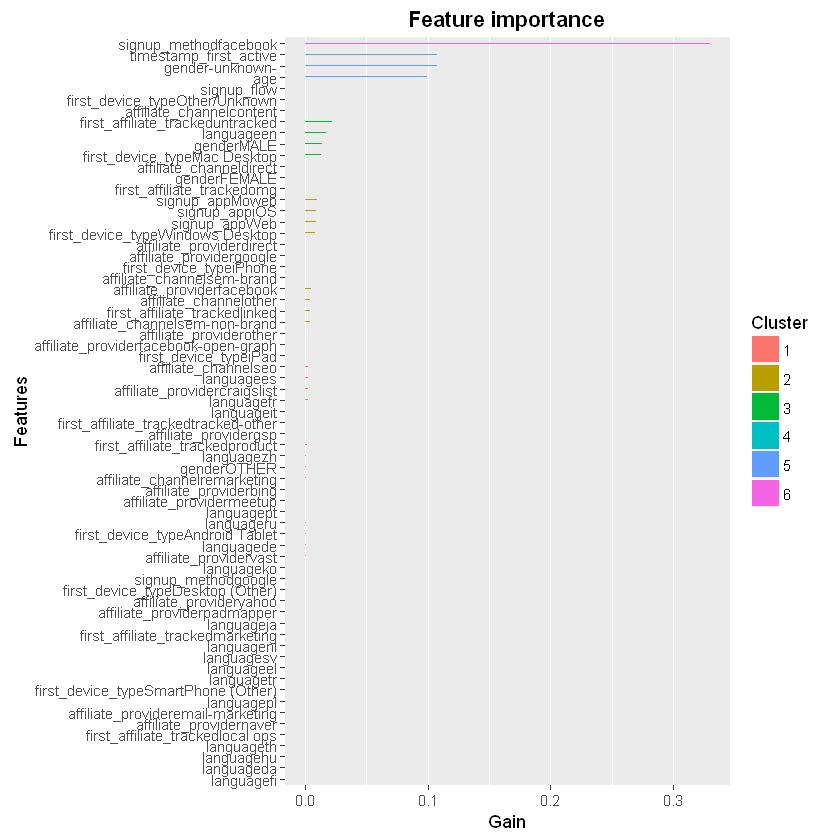

In [40]:
# Evaluating importance of features to the model
importance <- xgb.importance(sparse_tr@Dimnames[[2]], 
                             model = xgb_train_1$finalModel, 
                             data = sparse_tr, 
                             label = as.numeric(tr$country_destination)
                            )
xgb.plot.importance(importance_matrix = importance)

In [37]:
str(xgb_train_1$finalModel)
xgb_train_1$results$Kappa

List of 6
 $ handle     :Class 'xgb.Booster.handle' <externalptr> 
 $ raw        : raw [1:3937268] 00 00 00 3f ...
 $ xNames     : chr [1:75] "timestamp_first_active" "gender-unknown-" "genderFEMALE" "genderMALE" ...
 $ problemType: chr "Classification"
 $ tuneValue  :'data.frame':	1 obs. of  6 variables:
  ..$ nrounds         : num 50
  ..$ max_depth       : num 10
  ..$ eta             : num 0.01
  ..$ gamma           : num 1
  ..$ colsample_bytree: num 0.3
  ..$ min_child_weight: num 1
 $ obsLevels  : chr [1:12] "AU" "CA" "DE" "ES" ...
 - attr(*, "class")= chr "xgb.Booster"


[1] 0.1461876 0.1408894 0.1865335 0.1559760 0.1569216 0.1813830 0.1652422
 [8] 0.1727437 0.1870836 0.1733923 0.1759870 0.1826895 0.1740330 0.1785823
[15] 0.1887705

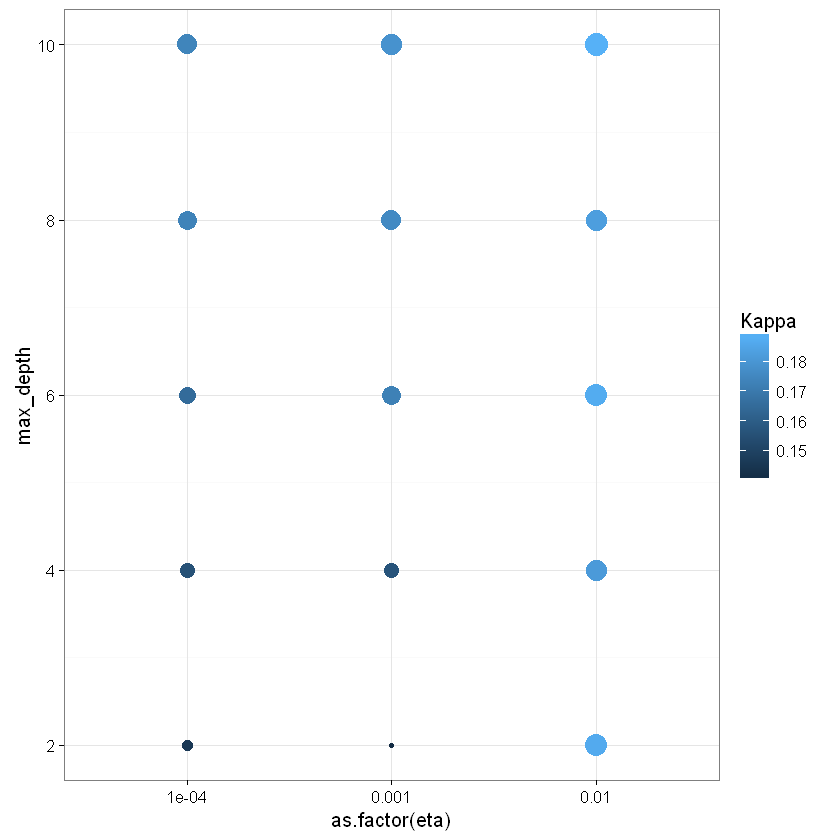

In [23]:
# scatter plot of the Kappa against max_depth and eta
ggplot(xgb_train_1$results, aes(x = as.factor(eta), y = max_depth, size = Kappa, color = Kappa)) + 
    geom_point() + 
    theme_bw() + 
    scale_size_continuous(guide = "none")

In [43]:
# Evaluate performance on test set
pred <- predict(xgb_train_1$finalModel, sparse_ts)

List of 6
 $ handle     :Class 'xgb.Booster.handle' <externalptr> 
 $ raw        : raw [1:3937268] 00 00 00 3f ...
 $ xNames     : chr [1:75] "timestamp_first_active" "gender-unknown-" "genderFEMALE" "genderMALE" ...
 $ problemType: chr "Classification"
 $ tuneValue  :'data.frame':	1 obs. of  6 variables:
  ..$ nrounds         : num 50
  ..$ max_depth       : num 10
  ..$ eta             : num 0.01
  ..$ gamma           : num 1
  ..$ colsample_bytree: num 0.3
  ..$ min_child_weight: num 1
 $ obsLevels  : chr [1:12] "AU" "CA" "DE" "ES" ...
 - attr(*, "class")= chr "xgb.Booster"


In [ ]:
# Generate predictions on competition test set. 
pred <- predict(xgb_train_1, sparse_test)
# compare prediction to results